# Polynomial fitting with confidence/prediction intervals

Marcos Duarte

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.2,
                rc={'font.size': 20, 'lines.linewidth': 1.5, 'lines.markersize': 14, 'axes.titlesize': 'x-large'})
import pandas as pd
import sys, os
sys.path.insert(1, r'./../functions')

Some data to play:

In [13]:
N = 60
x = np.sort(np.random.random(N)*6-2)  # N (ordered) values in [-2, 4]
y = np.polyval([3, 1, 4], x) + np.random.randn(N)*8
deg = 2

## Using Seaborn

Gives only confidence interval estimated by boostrapping (see http://seaborn.pydata.org/generated/seaborn.regplot.html).

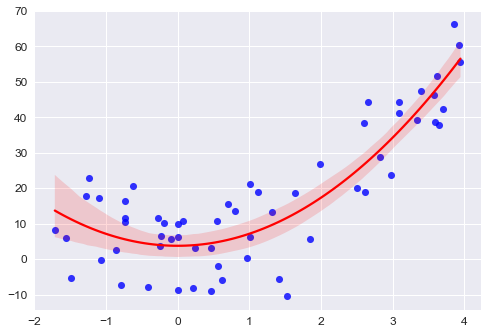

In [14]:
ax = sns.regplot(x=x, y=y, scatter_kws={"s": 50, "color": 'blue'}, line_kws={"color": 'red'},
                 order=deg, ci=95, truncate=True)

### How to access some of the data in the plot above

In [15]:
# all objects
obj = ax.get_children()
# line
xline = ax.get_lines()[0].get_xdata()
yline = ax.get_lines()[0].get_ydata()
# confidence interval
ci = ax.get_children()[1].get_paths()

# Using custom function

Implements the polynomial fit by least squares and calculates the confidence and prediction intervals assuming normal distribution of the residuals.  
The code of the `polyfit.py` function is at the end of this notebook (or download the function from the GitHub repo).

In [16]:
from polyfit import polyfit

In [17]:
help(polyfit)

Help on function polyfit in module polyfit:

polyfit(x, y, degree, plot=True, xlabel='x', ylabel='y', title=True, legend=True, plotCI=True, plotPI=True, axis=None)
    Least squares polynomial regression of order degree for x vs. y.
    
    Parameters
    ----------
    x : numpy array_like, shape (N,)
        Independent variable, x-coordinates of the N points (x[i], y[i]).
    y : numpy array_like, shape (N,)
        Dependent variable, y-coordinates of the N points (x[i], y[i]).
    degree : integer
        Degree of the polynomial to be fitted to the data.
    plot : : bool, optional (default = True)
        Show plot (True) of not (False). 
    xlabel : string, optional (default = 'x')
        Label for the x (horizontal) axis.
    ylabel : string, optional (default = 'y')
        Label for the y (vertical) axis.
    title : bool, optional (default = True)
        Show title (True) of not (False) in the plot.
    legend : bool, optional (default = True)
        Show legend (True)

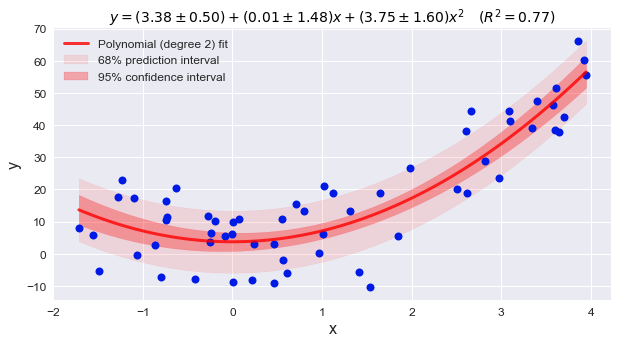

In [18]:
p, perr, R2, yfit, ci, pi = polyfit(x, y, deg)

Let's compare the results of linear and quadratic fits (this also shows how to use a given axis to plot there):

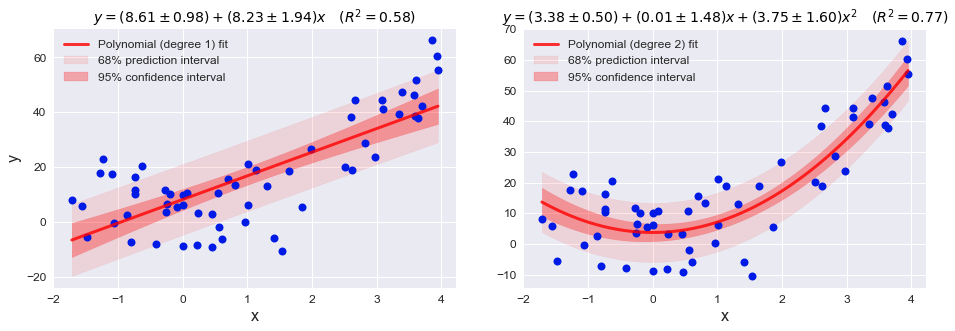

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
p, perr, R2, yfit, ci, pi = polyfit(x, y, degree=1, axis=ax[0])
p, perr, R2, yfit, ci, pi = polyfit(x, y, degree=2, axis=ax[1], ylabel='')
plt.tight_layout()

## P.S.: Calculation of moving standard-deviation

Let's calculate the moving standard-deviation just to compare with the 68% (1 SD) prediction interval for the fiited polynomial given in the plot above.

In [20]:
ys = pd.Series(y)
# use a moving window of one-tenth of the size of the data.
ys_std = ys.rolling(window=int(np.round(N/10)), min_periods=4, center=True).std()

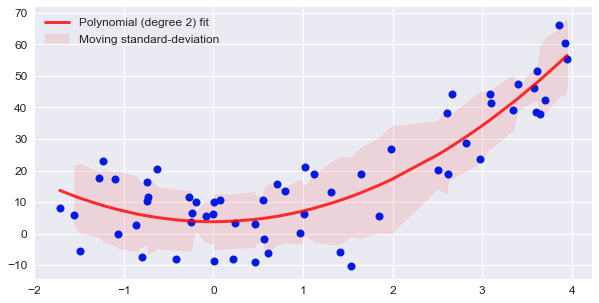

In [21]:
plt.figure(figsize=(10, 5))
plt.fill_between(x, yfit+ys_std, yfit-ys_std, color=[1, 0, 0, 0.1], edgecolor='',
                 label='Moving standard-deviation')
plt.plot(x, y, 'o', color=[0, 0.1, .9, 1], markersize=8)    
plt.plot(x, yfit, 'r', linewidth=3, color=[1, 0, 0, .8], label='Polynomial (degree {}) fit'.format(deg))
plt.legend()
plt.show()

## Function `polyfit.py`

In [ ]:
# %load ./../functions/polyfit.py
"""Least squares polynomial regression with confidence/prediction intervals.
"""

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = 'polyfit.py v.1.0.0 2017/04/16'
__license__ = "MIT"

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def polyfit(x, y, degree, plot=True, xlabel='x', ylabel='y', title=True,
            legend=True, plotCI=True, plotPI=True, axis=None):
    """Least squares polynomial regression of order degree for x vs. y.
    
    Parameters
    ----------
    x : numpy array_like, shape (N,)
        Independent variable, x-coordinates of the N points (x[i], y[i]).
    y : numpy array_like, shape (N,)
        Dependent variable, y-coordinates of the N points (x[i], y[i]).
    degree : integer
        Degree of the polynomial to be fitted to the data.
    plot : : bool, optional (default = True)
        Show plot (True) of not (False). 
    xlabel : string, optional (default = 'x')
        Label for the x (horizontal) axis.
    ylabel : string, optional (default = 'y')
        Label for the y (vertical) axis.
    title : bool, optional (default = True)
        Show title (True) of not (False) in the plot.
    legend : bool, optional (default = True)
        Show legend (True) of not (False) in the plot.
    plotCI : bool, optional (default = True)
        Plot the shaded area for the confidence interval (True) of not (False).
    plotPI : bool, optional (default = True)
        Plot the shaded area for the prediction interval (True) of not (False).
    axis : matplotlib object, optional (default = None)
        Matplotlib axis object where to plot.

    Returns
    -------    
    p : numpy array, shape (deg + 1,)
        Coefficients of the least squares polynomial fit.
    perr : numpy array, shape (deg + 1,)
        Standard-deviation of the coefficients.
    R2 : float
        Coefficient of determination.
    yfit : numpy array, shape (N + 1,)
        Values of the fitted polynomial evaluated at x.
    ci : numpy array, shape (N + 1,)
        Values of the 95% confidence interval evaluated at x.
    pi : numpy array, shape (N + 1,)
        Values of the 68% prediction interval evaluated at x.
        
    Examples
    --------
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> N = 100
    >>> x = np.sort(np.random.random(N)*6-2)
    >>> y = np.polyval([3, 1, 4], x) + np.random.randn(N)*10
    >>> fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    >>> p1, perr1, R21, yfit1, ci1, pi1 = polyfit(x, y, degree=1, axis=ax[0])
    >>> p2, perr2, R22, yfit2, ci2, pi2 = polyfit(x, y, degree=2, axis=ax[1])
    >>> plt.tight_layout()
    
    """
    
    x, y = np.asarray(x), np.asarray(y)
    N = y.size
    # coefficients and covariance matrix of the least squares polynomial fit
    p, cov = np.polyfit(x, y, degree, cov=True)
    # evaluate the polynomial at x
    yfit = np.polyval(p, x)            
    # standard-deviation of the coefficients
    perr = np.sqrt(np.diag(cov))                   
    # residuals
    res = y - yfit                                 
    # reduced chi-squared
    chi2red = np.sum(res**2)/(N - degree - 1)         
    # standard deviation of the error (residuals)
    s_err = np.sqrt(np.sum(res**2)/(N - degree - 1))  
    # sum of squared residuals
    SSres = np.sum(res**2)                            
    # sum of squared totals
    SStot = np.sum((y - np.mean(y))**2)              
    # coefficient of determination
    R2 = 1 - SSres/SStot                               
    # adjusted coefficient of determination
    R2adj = 1 - (SSres/(N - degree - 1)) / (SStot/(N - 1))
    # 95% (2 SD) confidence interval for the fit
    t95 = stats.t.ppf(0.95 + (1-0.95)/2, N - degree - 1)
    ci = t95 * s_err * np.sqrt(    1/N + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # 68% (1 SD) prediction interval for the fit
    t68 = stats.t.ppf(0.683 + (1-0.683)/2, N - degree - 1)
    pi = t68 * s_err * np.sqrt(1 + 1/N + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # plot
    if plot:
        # generate values if number of input values is too small or too large
        if N < 50 or N > 200:
            x2 = np.linspace(np.min(x), np.max(x), 100)
            yfit2 = np.polyval(p, x2)
            ci2 = np.interp(x2, x, ci)
            pi2 = np.interp(x2, x, pi)
        else:
            x2, yfit2, ci2, pi2 = x, yfit, ci, pi

        if axis is None:
            fig, axis = plt.subplots(1, 1, figsize=(10, 5))
        else:
            fig = 0
        if plotPI:
            axis.fill_between(x2, yfit2+pi2, yfit2-pi2, color=[1, 0, 0, 0.1],
                              edgecolor='', label='68% prediction interval')
        if plotCI:
            axis.fill_between(x2, yfit2+ci2, yfit2-ci2, color=[1, 0, 0, 0.3],
                              edgecolor='', label='95% confidence interval')
        axis.plot(x, y, 'o', color=[0, 0.1, .9, 1], markersize=8)
        axis.plot(x2, yfit2, 'r', linewidth=3, color=[1, 0, 0, .8],
                 label='Polynomial (degree {}) fit'.format(degree))
        axis.set_xlabel(xlabel, fontsize=16)
        axis.set_ylabel(ylabel, fontsize=16)
        if legend:
            axis.legend()
        if title:
            xs = ['', 'x'] + ['x^{:d}'.format(ideg) for ideg in range(2, degree+1)]
            title = ['({:.2f} \pm {:.2f}) {}'.format(i, j, k) for i, j, k in zip(p, perr, xs)]
            R2str = '\quad (R^2 = ' + '{:.2f}'.format(R2) + ')'
            title = '$ y = ' + '+'.join(title) + R2str + '$'
            axis.set_title(title, fontsize=14, color=[0, 0, 0])  
        if fig:
            plt.show()
    
    return p, perr, R2, yfit, ci, pi